In [ ]:
from google.colab import files

In [ ]:
# Importer le dossier de l'envionnement s'il n'existe pas dans les Files.
! pip install -e fc-impersonation-detection
import sys
sys.path.append("/content/fc-impersonation-detection")

Obtaining file:///content/fc-impersonation-detection
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 15.7 MB/s eta 0:00:00
  Running setup.py develop for gym_fc_impersonation_detection


In [ ]:
# Ignorer au prime abord
import os

def restart_runtime():
  os.kill(os.getpid(), 9)

restart_runtime()

In [ ]:
!sudo apt update
!sudo apt install dirmngr ca-certificates software-properties-common gnupg gnupg2 apt-transport-https curl -y
!curl -fSsL https://www.postgresql.org/media/keys/ACCC4CF8.asc | gpg --dearmor | sudo tee /usr/share/keyrings/postgresql.gpg > /dev/null
!echo 'deb [arch=amd64,arm64,ppc64el signed-by=/usr/share/keyrings/postgresql.gpg] http://apt.postgresql.org/pub/repos/apt/ jammy-pgdg main' | sudo tee /etc/apt/sources.list.d/pgdg.list
!sudo apt update
!sudo apt install postgresql-client-15 postgresql-15 -y
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "CREATE ROLE root WITH SUPERUSER;"
!sudo -u postgres psql -U postgres -c "ALTER ROLE root WITH LOGIN;"
!sudo -u postgres psql -U postgres -c "CREATE ROLE postgres WITH PASSWORD 'postgres';"
!sudo -u postgres psql -c "ALTER USER postgres PASSWORD 'postgres';"
!sudo -u postgres psql -c "CREATE TABLE root;"

# TimescaleDB
! echo "deb https://packagecloud.io/timescale/timescaledb/ubuntu/ $(lsb_release -c -s) main" | sudo tee /etc/apt/sources.list.d/timescaledb.list
! wget --quiet -O - https://packagecloud.io/timescale/timescaledb/gpgkey | sudo gpg --dearmor -o /etc/apt/trusted.gpg.d/timescaledb.gpg
! sudo apt update
! sudo apt install -y timescaledb-2-postgresql-15 postgresql-client-15
! sudo timescaledb-tune
! sudo systemctl restart postgresql

# DB
! sudo -u postgres psql -c "CREATE TABLE training_steps_data (id SERIAL PRIMARY KEY, episode INT, step INT, state INT, lambda_threshold FLOAT, is_legit BOOLEAN, L_value FLOAT, v_channel_vector FLOAT, r_channel_record FLOAT, decision_made BOOLEAN, reward FLOAT, far FLOAT, mdr FLOAT, aer FLOAT, q_value_a FLOAT, q_value_b FLOAT, politique_pi FLOAT, timestamp TIMESTAMPTZ DEFAULT NOW());"
! sudo -u postgres psql -c "SELECT create_hypertable('"training_steps_data"', 'timestamp');"

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:7 http://apt.postgresql.org/pub/repos/apt jammy-pgdg InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://packagecloud.io/timescale/timescaledb/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:14 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state informatio

In [ ]:
import psycopg2
import logging
from psycopg2 import extras
import numpy as np

class PostgreSQLAgent:
    def __init__(self, db_name, user, password, host='localhost', port='5432'):
        try:
            self.conn = psycopg2.connect(
                dbname=db_name,
                user=user,
                password=password,
                host=host,
                port=port
            )
            self.cursor = self.conn.cursor()
        except psycopg2.DatabaseError as e:
            logging.error(f"Erreur de connexion à la base de données : {e}")
            raise

    # Méthode pour insérer en masse des décisions
    def insert_training_steps_data_bulk(self, decisions_data):
          try:
              query = """
              INSERT INTO training_steps_data (episode, step, state, lambda_threshold, is_legit, L_value, v_channel_vector, r_channel_record, decision_made, reward, far, mdr, aer, q_value_a, q_value_b, politique_pi)
              VALUES %s;
              """
              extras.execute_values(self.cursor, query, decisions_data)
              self.conn.commit()
          except psycopg2.DatabaseError as e:
              logging.error(f"Erreur lors de l'insertion en masse des décisions dans training_steps_data : {e}")
              self.conn.rollback()

    # Nouvelle méthode pour récupérer les données de décisions avec jointure
    def fetch_decisions_data(self):
        try:
            query = """
            SELECT lambda_threshold, L_value, decision_made, v_channel_vector, r_channel_record, reward, is_legit
            FROM training_steps_data
            LIMIT 600
            """
            self.cursor.execute(query)
            decision_data = self.cursor.fetchall()
            return np.array(decision_data)
        except psycopg2.DatabaseError as e:
            logging.error(f"Erreur lors de la récupération des données de décisions : {e}")
            self.conn.rollback()
            return None

    # Nouvelle méthode pour récupérer les données de décisions avec jointure
    def fetch_decisions_data_min(self):
        try:
            query = """
            SELECT lambda_threshold, L_value, decision_made, v_channel_vector, r_channel_record
            FROM training_steps_data
            LIMIT 200
            """
            self.cursor.execute(query)
            decision_data = self.cursor.fetchall()
            return np.array(decision_data)
        except psycopg2.DatabaseError as e:
            logging.error(f"Erreur lors de la récupération des données de décisions : {e}")
            self.conn.rollback()
            return None

    def close(self):
        try:
            self.cursor.close()
            self.conn.close()
        except psycopg2.DatabaseError as e:
            logging.error(f"Erreur lors de la fermeture de la connexion à la base de données : {e}")

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:485: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:317: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


Simulation pour ω = 10 dB


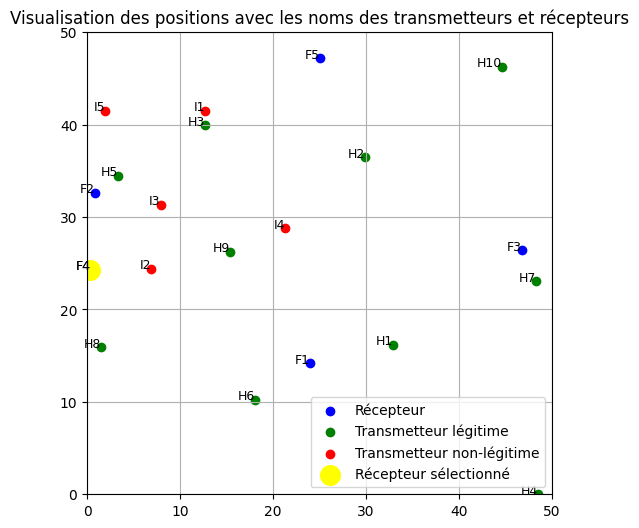

/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:212: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:245: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'bool'>
  logger.warn(


Épisode 1/30 | FAR: 0.6449, MDR: 0.4869, AER: 1.1318, Utility: 1.2631




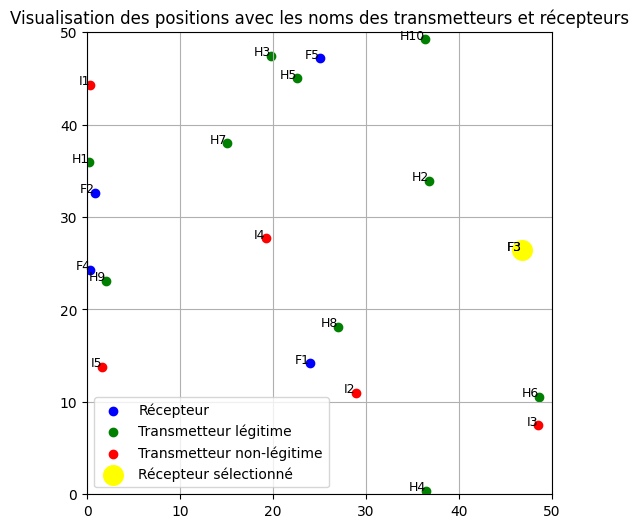

Épisode 2/30 | FAR: 0.6419, MDR: 0.4859, AER: 1.1278, Utility: 0.5731




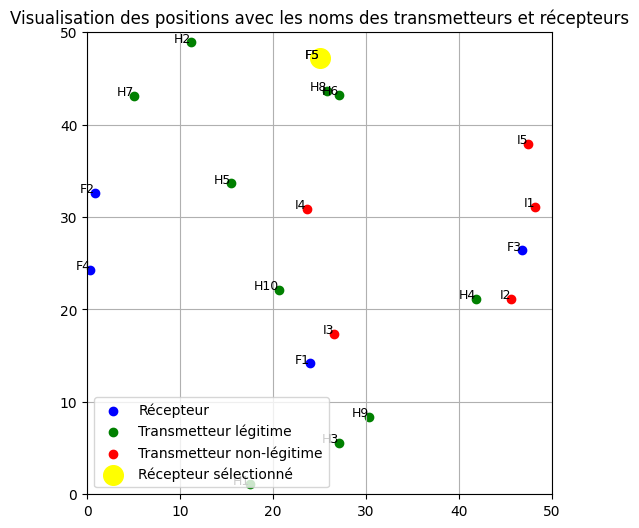

Épisode 3/30 | FAR: 0.7027, MDR: 0.4174, AER: 1.1201, Utility: 1.1479




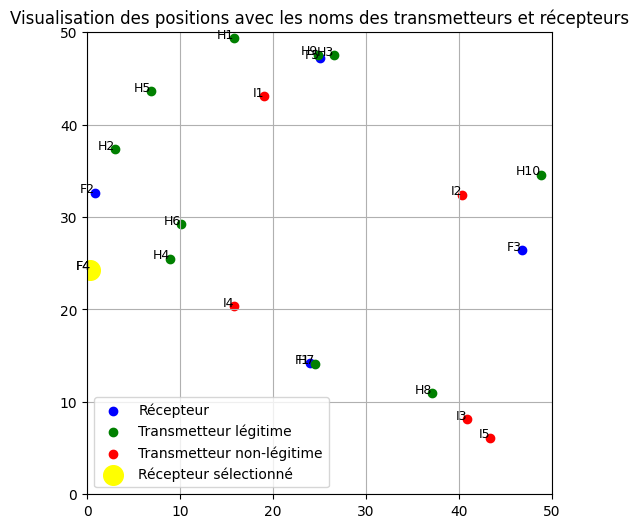

Épisode 4/30 | FAR: 0.5500, MDR: 0.5867, AER: 1.1367, Utility: 1.8192




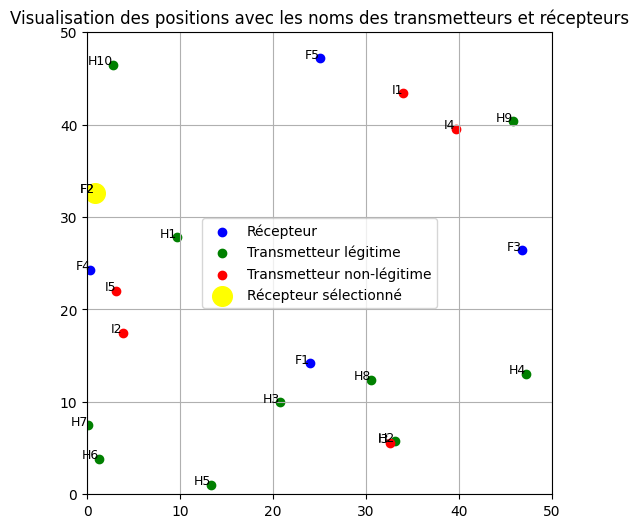

Épisode 5/30 | FAR: 0.6020, MDR: 0.5283, AER: 1.1302, Utility: 0.9097




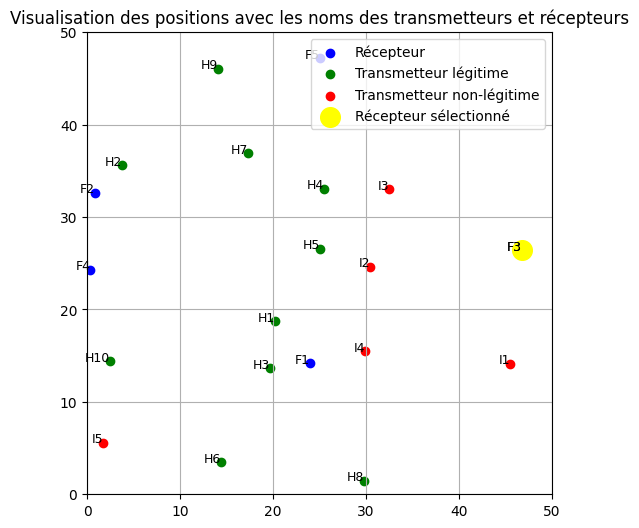

Épisode 6/30 | FAR: 0.6857, MDR: 0.4364, AER: 1.1222, Utility: 1.0661




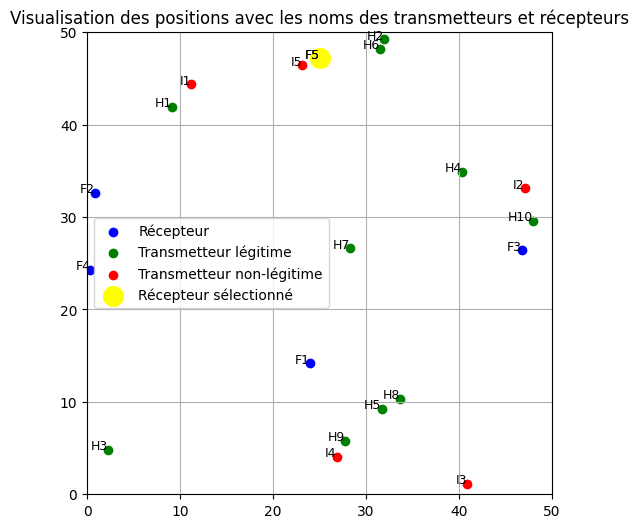

Épisode 7/30 | FAR: 0.6026, MDR: 0.5282, AER: 1.1307, Utility: 1.3296




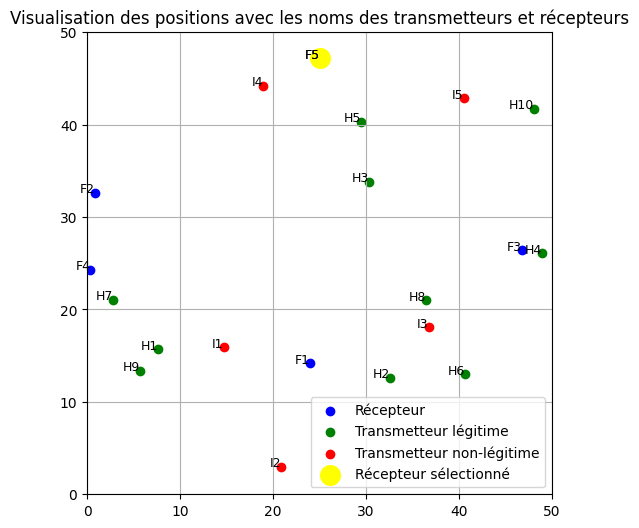

Épisode 8/30 | FAR: 0.6606, MDR: 0.4649, AER: 1.1256, Utility: 0.5625




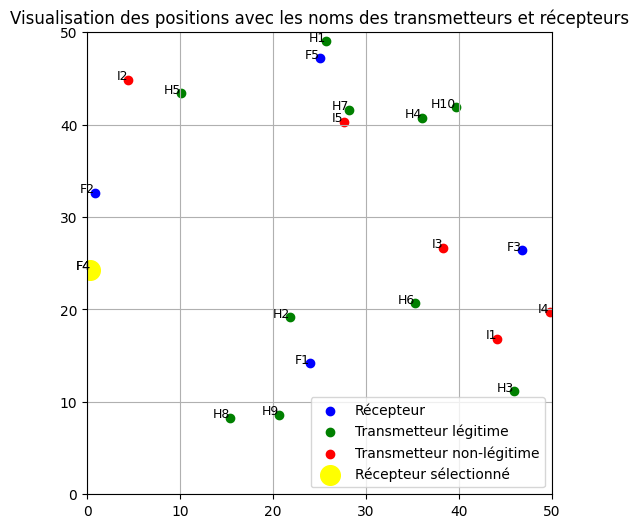

Épisode 9/30 | FAR: 0.6051, MDR: 0.5288, AER: 1.1339, Utility: 1.0596




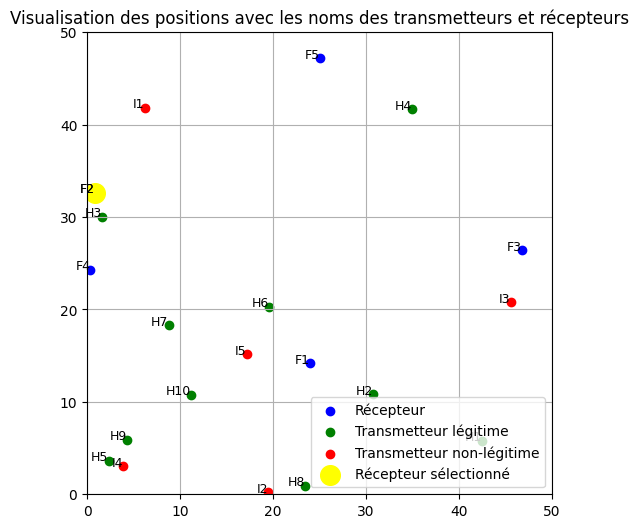

Épisode 10/30 | FAR: 0.7228, MDR: 0.3969, AER: 1.1197, Utility: 1.2818




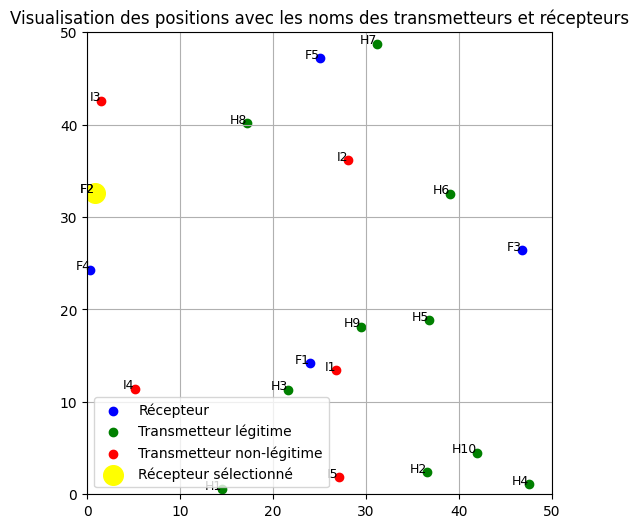

Épisode 11/30 | FAR: 0.6414, MDR: 0.4857, AER: 1.1271, Utility: 1.2240




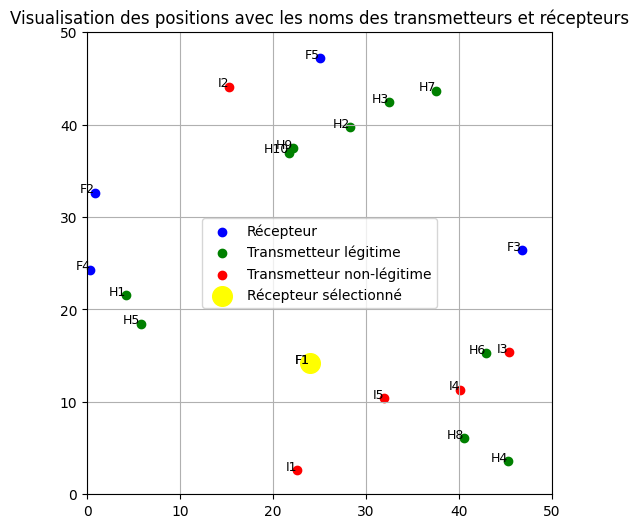

Épisode 12/30 | FAR: 0.5194, MDR: 0.6162, AER: 1.1356, Utility: 0.9088




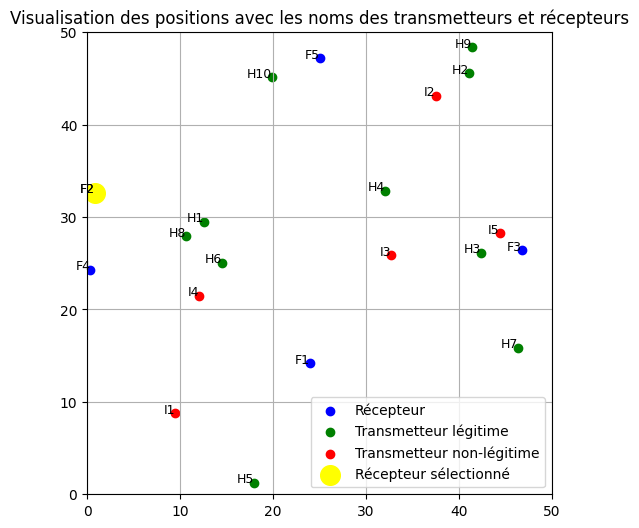

Épisode 13/30 | FAR: 0.6331, MDR: 0.4950, AER: 1.1281, Utility: 1.2589




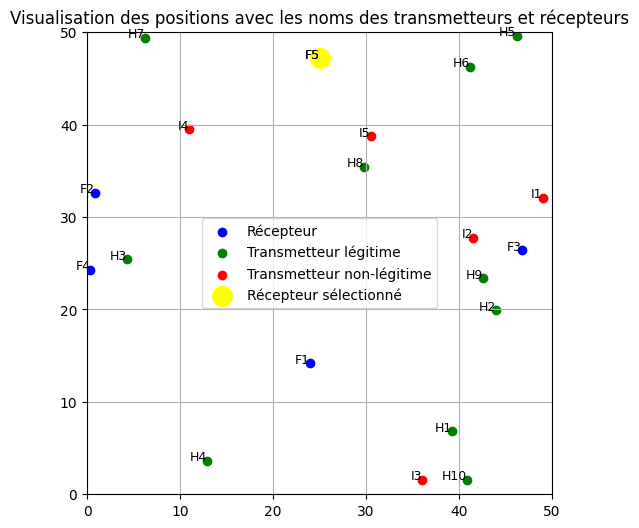

Épisode 14/30 | FAR: 0.6167, MDR: 0.5123, AER: 1.1290, Utility: 1.6339




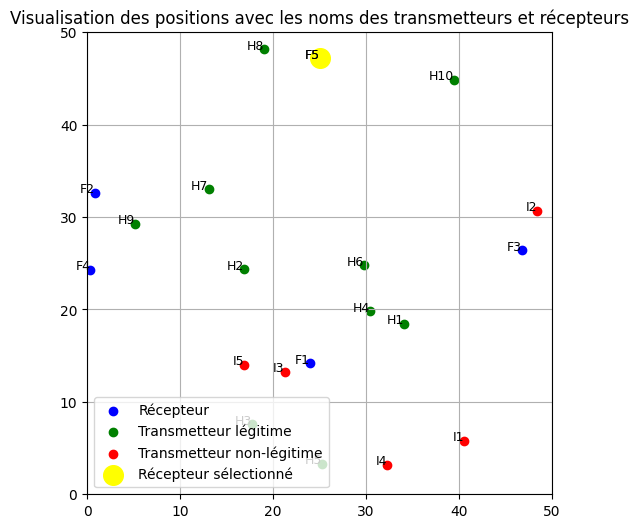

Épisode 15/30 | FAR: 0.8119, MDR: 0.2974, AER: 1.1093, Utility: 1.2492




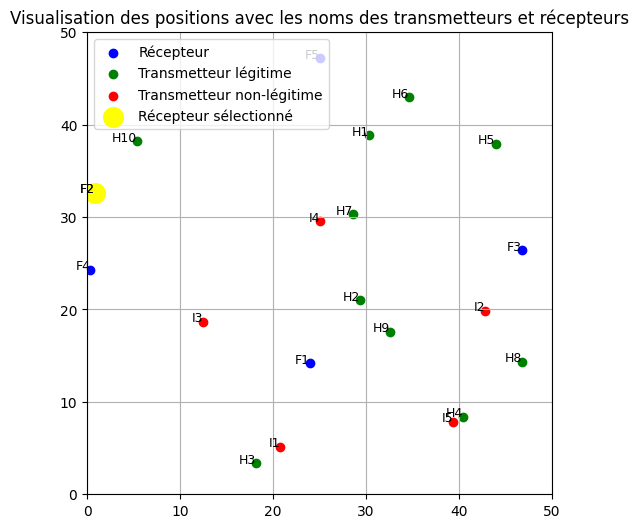

Épisode 16/30 | FAR: 0.7434, MDR: 0.3750, AER: 1.1183, Utility: 1.4788




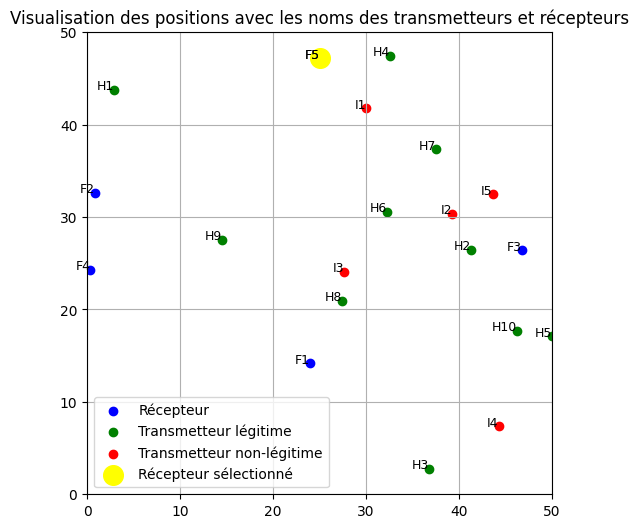

Épisode 17/30 | FAR: 0.6273, MDR: 0.5028, AER: 1.1302, Utility: 1.5535




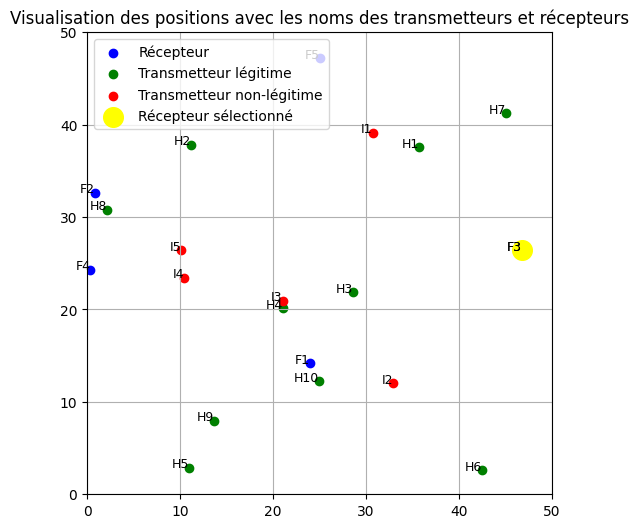

Épisode 18/30 | FAR: 0.7488, MDR: 0.3667, AER: 1.1155, Utility: 1.0114




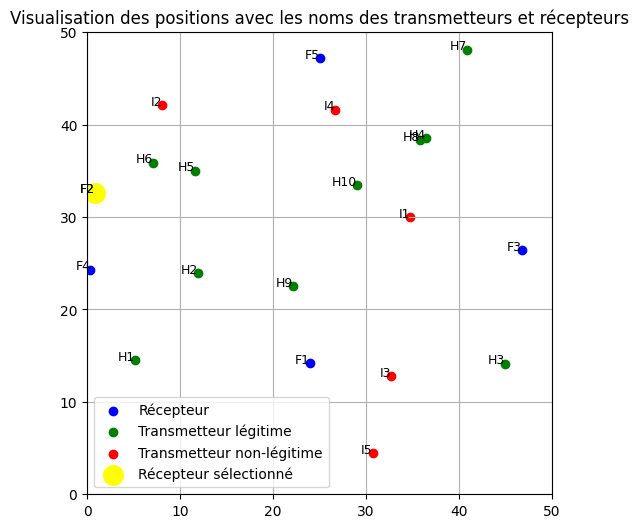

Épisode 19/30 | FAR: 0.6821, MDR: 0.4434, AER: 1.1255, Utility: 0.5864




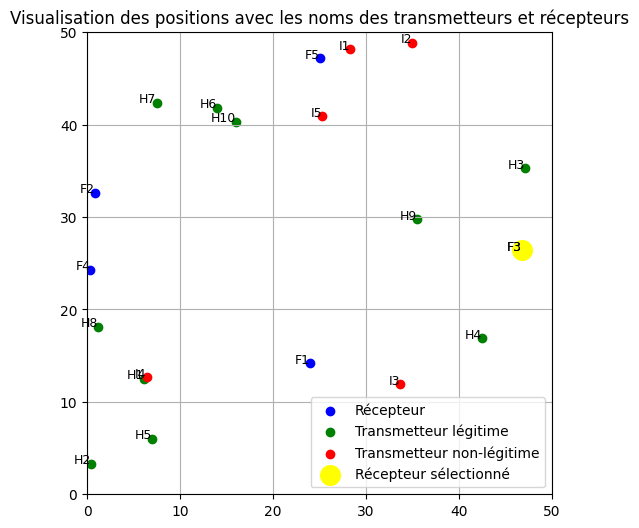

Épisode 20/30 | FAR: 0.7727, MDR: 0.3399, AER: 1.1126, Utility: 1.3836




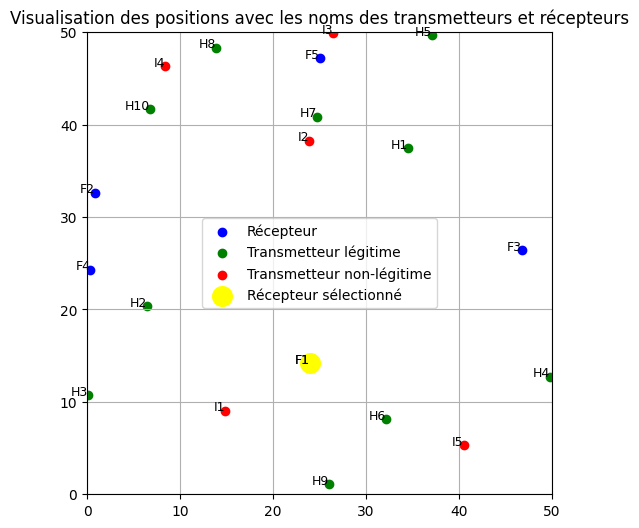

Épisode 21/30 | FAR: 0.7198, MDR: 0.3983, AER: 1.1181, Utility: 1.5924




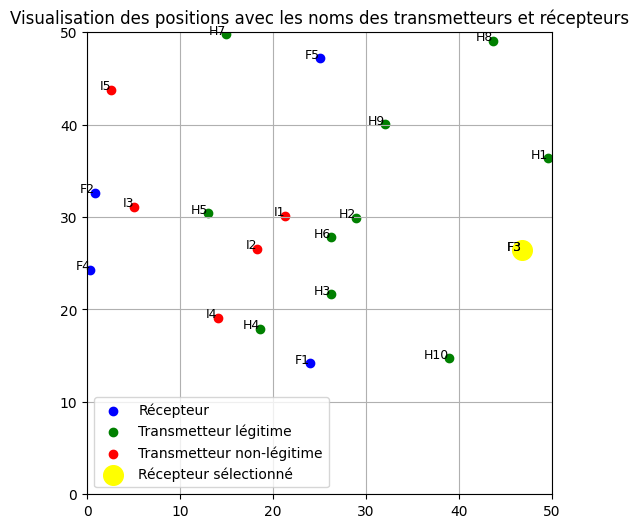

Épisode 22/30 | FAR: 0.6595, MDR: 0.4668, AER: 1.1263, Utility: 0.7790




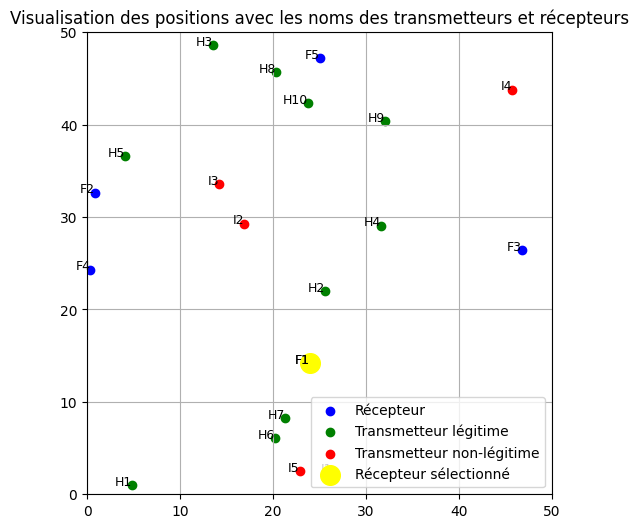

Épisode 23/30 | FAR: 0.7326, MDR: 0.3862, AER: 1.1188, Utility: 0.6670




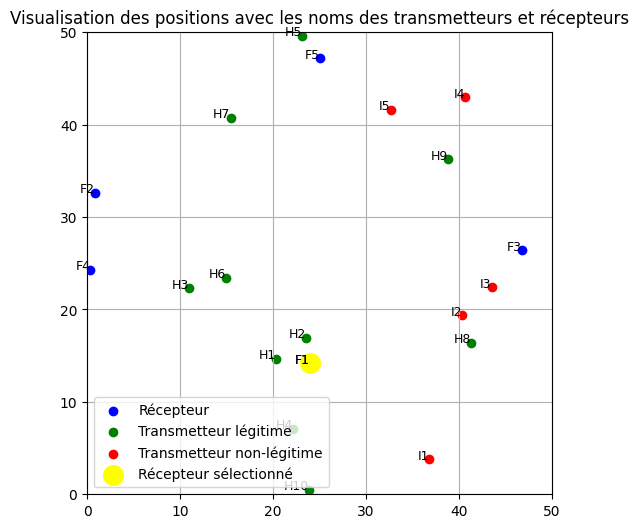

Épisode 24/30 | FAR: 0.7610, MDR: 0.3529, AER: 1.1139, Utility: 1.4804




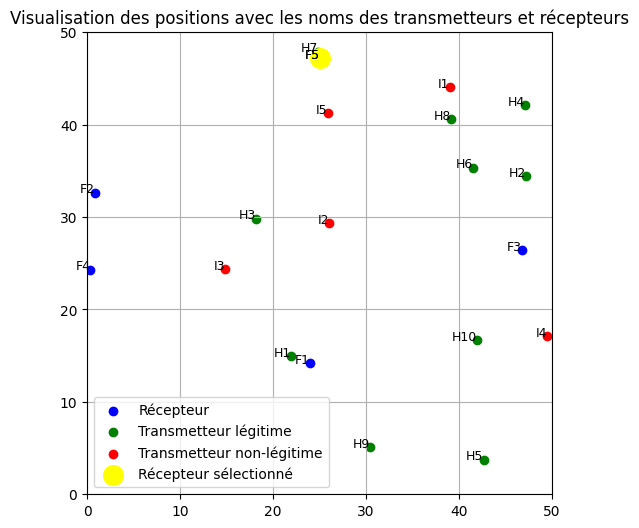

Épisode 25/30 | FAR: 0.8520, MDR: 0.2521, AER: 1.1041, Utility: 1.1729




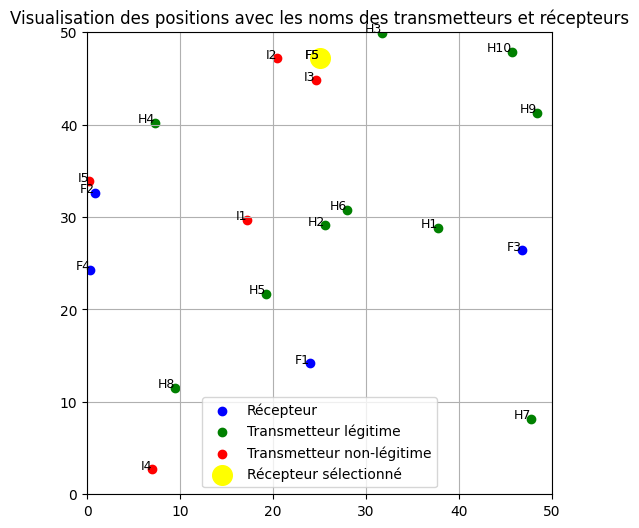

Épisode 26/30 | FAR: 0.5996, MDR: 0.5323, AER: 1.1319, Utility: 1.2560




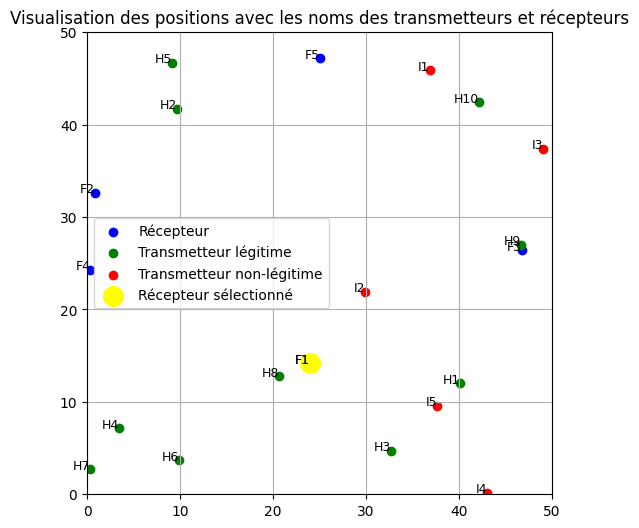

Épisode 27/30 | FAR: 0.6606, MDR: 0.4629, AER: 1.1235, Utility: 0.9686




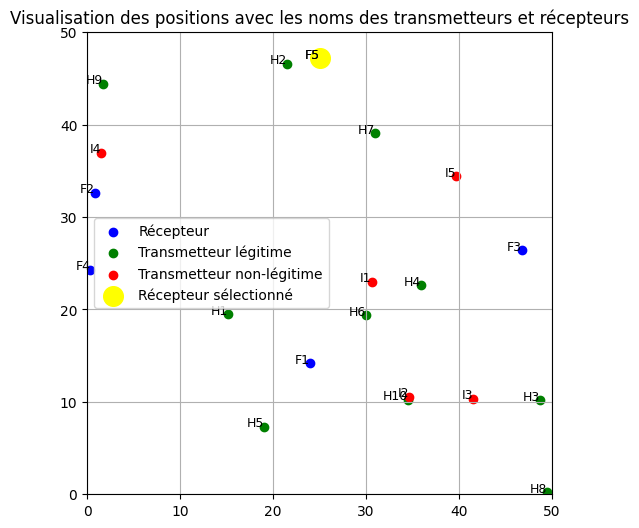

Épisode 28/30 | FAR: 0.7196, MDR: 0.3999, AER: 1.1194, Utility: 0.6804




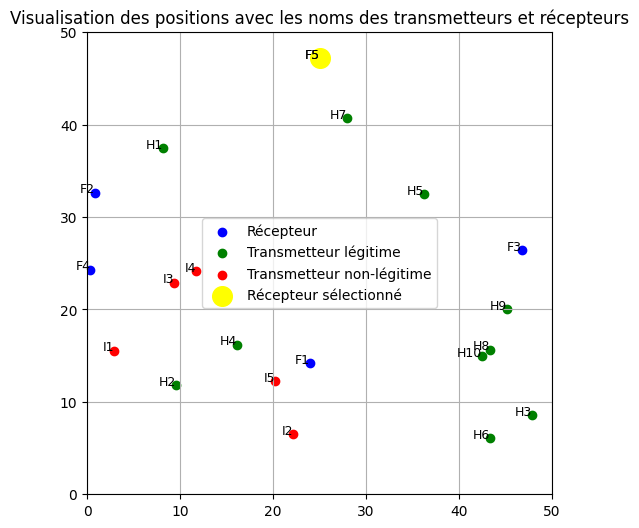

Épisode 29/30 | FAR: 0.5987, MDR: 0.5311, AER: 1.1298, Utility: 1.1950




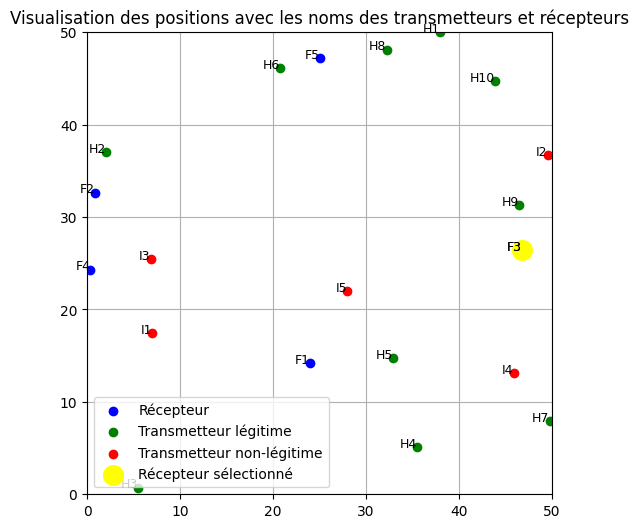

Épisode 30/30 | FAR: 0.7166, MDR: 0.4046, AER: 1.1212, Utility: 1.4683


Résumé pour ω = 10 dB -> FAR moyen: 0.6745, MDR moyen: 0.4494, AER moyen: 1.1239, Utility moyenne: 1.1520, Threshold: 0.6306



In [ ]:
! pip install gymnasium
import numpy as np
import scipy.stats as stats
import gymnasium as gym
import matplotlib.pyplot as plt
import gym_fc_impersonation_detection

class DoubleSarsaSimulation:

    ################################################################################################
    def __init__(self, db_agent, r1=4, r2=2, l1=6, l2=9, mu=0.9, gamma=0.6, epsilon=0.5, n=3, xi_squared=5, m=0.2, omega=20, f0=2.4, T=20, N=30, area_size=50, nbr_legitimate_users=10, nbr_not_legitimate_users=5, nbr_receivers=5) :

        # Building the environment
        self.T = T  # Nombre de d'etapes
        self.N = N  # Nombre épisodes
        self.L = 50
        self.gamma = gamma  # Taux de remise
        self.epsilon = epsilon  # Stratégie épsilon-gourmande
        self.mu = mu  # Efficacité d'apprentissage
        self.omega = omega
        self.n = n
        self.m = m
        self.xi_squared = xi_squared
        self.action_max_value = 2.0
        self.action_min_value = 0.1
        self.actions = [self.action_min_value + (self.action_max_value / (self.L - 1)) * i for i in range(self.L+1)]
        self.env = gym.make("FCImpersonationDetection-v0", r1=r1, r2=r2, l1=l1, l2=l2, n=n, xi_squared=xi_squared, m=m, omega=omega, f0=f0, L=self.L, area_size=area_size, nbr_legitimate_users=nbr_legitimate_users, nbr_not_legitimate_users=nbr_not_legitimate_users, nbr_receivers=nbr_receivers, actions=self.actions)

        # Initialisation des Q-tables
        self.QA = np.zeros((self.env.get_wrapper_attr('observation_space_n'), self.env.get_wrapper_attr('action_space_n')))
        self.QB = np.zeros((self.env.get_wrapper_attr('observation_space_n'), self.env.get_wrapper_attr('action_space_n')))
        self.pi = np.zeros(self.env.get_wrapper_attr('action_space_n'))

        self.db_agent = db_agent  # Agent PostgreSQL pour stocker les données
    ################################################################################################

    ################################################################################################
    # Function to choose the next action
    def choose_action(self, state):
        lambda_threshold = self.action_min_value
        if np.random.uniform(0, 1) < self.epsilon:
            lambda_threshold = self.env.action_space.sample()
        else:
            lambda_threshold = np.argmax(self.pi)
        return lambda_threshold
    ################################################################################################

    ################################################################################################
    # Fonction pour calculer les probabilités P1 et P2
    def calculate_p1_p2(self, lambda_threshold):
        P1_lambda = 1 - (self.calculate_fx((2 * lambda_threshold * self.omega) / (2 * (self.omega ** 2) + self.n * self.omega * self.xi_squared)))
        P2_lambda = self.calculate_fx((2 * lambda_threshold * self.omega) / (2 * (self.omega ** 2) + (1 + self.m) * self.omega * self.xi_squared))
        return P1_lambda, P2_lambda
    ################################################################################################

    ################################################################################################
    # Fonction pour calculer la fonction cumulative distribution F_X2
    def calculate_fx(self, value):
        return stats.chi2.cdf(value, 2)
    ################################################################################################

    ################################################################################################
    def update_q_tables(self, state, lambda_threshold, utility, next_state, lambda_threshold_prime):
        # Calcul des valeurs lambda optimales pour Q^A et Q^B
        lambda_A_prime = np.argmax(self.QA[next_state, :])
        lambda_B_prime = np.argmax(self.QB[next_state, :])

        # Mise à jour des Q-tables
        if np.random.rand() < 0.5:
            # Mise à jour de Q^A
            self.QA[state, lambda_threshold] = (1 - self.mu) * self.QA[state, lambda_threshold] + \
                self.mu * (utility + self.gamma * self.QB[next_state, lambda_A_prime])
        else:
            # Mise à jour de Q^B
            self.QB[state, lambda_threshold] = (1 - self.mu) * self.QB[state, lambda_threshold] + \
                self.mu * (utility + self.gamma * self.QA[next_state, lambda_B_prime])
    ################################################################################################

    ################################################################################################
    def run_simulation(self):

        FAR_list, MDR_list, AER_list, utility_list = [], [], [], []

        for episode in range(self.N):

            state, info = self.env.reset()

            t, far_episode, mdr_episode, aer_episode, utility_episode = 0, 0, 0, 0, 0
            decisions_to_insert = []  # Liste pour cumuler les décisions de cet épisode

            lambda_threshold = self.choose_action(state)

            self.env.render()

            while t < self.T:

                P1, P2 = self.calculate_p1_p2(lambda_threshold)

                unwrapped_env = self.env.unwrapped

                try:
                    unwrapped_env.set_probabilities(P1, P2)
                except AttributeError:
                    print("Error: 'FCImpersonationDetection-v0' environment does not have a 'set_probabilities' method.")

                # Take the action and observe the result
                next_state, done, truncated, step_training_data = self.env.step(lambda_threshold)

                step, is_legit, reward, L_value, detection, v_channel_vector, r_channel_record = t + 1, step_training_data['is_legit'], step_training_data['reward'], step_training_data['L_value'], step_training_data['detection'], step_training_data['V_channel_transmitted'], step_training_data['R_channel_received']

                # Choosing the next action
                lambda_threshold_prime = self.choose_action(next_state)

                #print(L_value, lambda_threshold, reward, v_channel_vector, r_channel_record, is_legit, detection)

                # Update the Q-value
                self.update_q_tables(state, lambda_threshold, reward, next_state, lambda_threshold_prime)

                pi_st = np.max((self.QA[state, :] + self.QB[state, :]) / 2)
                self.pi[lambda_threshold] = pi_st

                # print(
                #     episode, "episode",
                #     step,
                #     state,
                #     self.actions[lambda_threshold],
                #     is_legit,
                #     L_value,
                #     v_channel_vector,
                #     r_channel_record, "r_channel_record",
                #     detection,
                #     float(reward),
                #     float(P1),
                #     float(P2),
                #     float(P1+P2), "aer",
                #     float(np.max(self.QA[state, :])),
                #     float(np.max(self.QB[state, :])),
                #     float(pi_st)
                # )

                decisions_to_insert.append((
                    episode,
                    step,
                    state,
                    self.actions[lambda_threshold],
                    is_legit,
                    L_value,
                    v_channel_vector,
                    r_channel_record,
                    detection,
                    float(reward),
                    float(P1),
                    float(P2),
                    float(P1+P2),
                    float(np.max(self.QA[state, :])),
                    float(np.max(self.QB[state, :])),
                    float(pi_st)
                ))

                state = next_state
                lambda_threshold = lambda_threshold_prime

                # Accumulation des métriques pour l'épisode
                far_episode += P1
                mdr_episode += P2
                aer_episode += (P1+P2)
                utility_episode += reward

                if done:
                    break
                else:
                  t += 1

            # Affichage des résultats
            print(f"Épisode {episode + 1}/{self.N} | FAR: {far_episode/t:.4f}, MDR: {mdr_episode/t:.4f}, AER: {aer_episode/t:.4f}, Utility: {utility_episode/t:.4f}")
            print("\n")

            # Une fois tous les créneaux temporels terminés, insérer les décisions en une seule fois
            self.db_agent.insert_training_steps_data_bulk(decisions_to_insert)

            # Stocker les moyennes pour l'analyse finale
            FAR_list.append(far_episode / t)
            MDR_list.append(mdr_episode / t)
            AER_list.append(aer_episode / t)
            utility_list.append(utility_episode / t)

        self.lambda_star = self.actions[np.argmax(self.pi)]

        return np.mean(FAR_list), np.mean(MDR_list), np.mean(AER_list), np.mean(utility_list), self.lambda_star
    ################################################################################################

    ################################################################################################
    # Fonction pour exécuter la simulation sur différentes valeurs de SINR (ω)
    def run(self):
        print(f"Simulation pour ω = 10 dB")
        test_FAR, test_MDR, test_AER, test_utility, test_threshold = self.run_simulation()
        print(f"Résumé pour ω = 10 dB -> FAR moyen: {test_FAR:.4f}, MDR moyen: {test_MDR:.4f}, AER moyen: {test_AER:.4f}, Utility moyenne: {test_utility:.4f}, Threshold: {test_threshold:.4f}\n")
    ################################################################################################

    ################################################################################################

# Instancier et exécuter la simulation
db_agent = PostgreSQLAgent(db_name='', user='postgres', password='postgres')
simulation = DoubleSarsaSimulation(db_agent=db_agent)
simulation.run()

Modèle de décisions entraîné avec succès.
Précision du modèle : 0.99


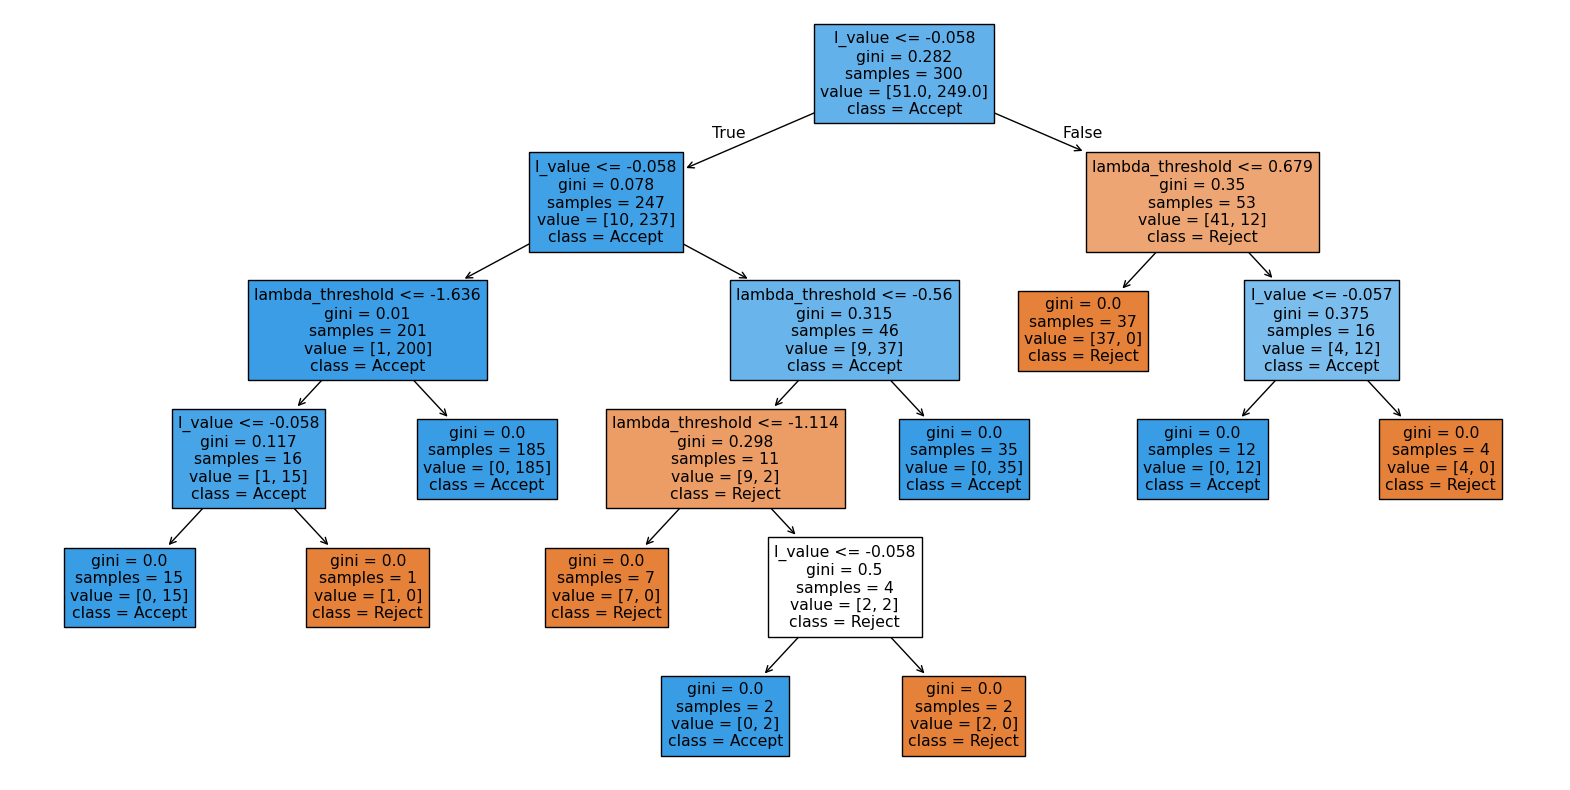

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score

class InterpretabilityAgent:
    def __init__(self):
        self.scaler_minmax = MinMaxScaler()
        self.scaler_standard = StandardScaler()
        self.model_decision = DecisionTreeClassifier()  # Modèle pour les décisions (arbre de décision)

    # Méthode pour normaliser les données de décisions
    def normalize_decision_data(self, X_train, X_test):
        X_train_normalized = self.scaler_standard.fit_transform(X_train)
        X_test_normalized = self.scaler_standard.transform(X_test)
        return X_train_normalized, X_test_normalized

    # Méthode pour entraîner le modèle de décisions
    def train_decision_model(self, X_train, y_train):
        self.model_decision.fit(X_train, y_train)
        print("Modèle de décisions entraîné avec succès.")

    # Méthode pour faire des prédictions sur les décisions
    def predict_decision(self, X_test):
        return self.model_decision.predict(X_test)

    # Méthode pour évaluer les prédictions
    def evaluate_model(self, X_test, y_test):
        y_pred = self.predict_decision(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Précision du modèle : {accuracy:.2f}")
        return accuracy

    # Méthode pour afficher l'arbre de décision
    def plot_decision_tree(self):
        if hasattr(self.model_decision, 'tree_'):
            plt.figure(figsize=(20, 10))
            plot_tree(self.model_decision, filled=True,
                      feature_names=['lambda_threshold', 'l_value'],
                      class_names=['Reject', 'Accept'])
            plt.show()
        else:
            print("Le modèle n'est pas encore entraîné. Entraînez d'abord le modèle avant de l'afficher.")


# Exemple d'utilisation
if __name__ == "__main__":
    # Supposons que db_agent est déjà initialisé et connecté à la base de données
    db_agent = PostgreSQLAgent(db_name='', user='postgres', password='postgres')

    # Récupérer les données de décisions via l'agent PostgreSQL
    decision_data = db_agent.fetch_decisions_data()

    # Sauvegarder le tableau NumPy en fichier CSV
    #np.savetxt('fc_impersonation_detection_dataset.csv', decision_data, delimiter=',', header="lambda_threshold,L_value,decision,v_channel_vector,r_channel_record,reward,legit_transmitter", comments='')

    # Séparer les caractéristiques (lambda_threshold, l_value) et la cible (decision_made)
    X = decision_data[:, [0, 1]]  # Caractéristiques : lambda_threshold, l_value
    y = decision_data[:, 2]  # Cible : decision_made

    # Séparation des données en ensembles d'entraînement et de test (50/50)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

    # Création de l'agent d'interprétabilité
    interpret_agent = InterpretabilityAgent()

    # Normalisation des données
    X_train_normalized, X_test_normalized = interpret_agent.normalize_decision_data(X_train, X_test)

    # Entraîner le modèle de décision sur les données d'entraînement
    interpret_agent.train_decision_model(X_train_normalized, y_train)

    # Évaluer le modèle sur les données de test
    interpret_agent.evaluate_model(X_test_normalized, y_test)

    # Afficher l'arbre de décision entraîné
    interpret_agent.plot_decision_tree()

Données de décisions récupérées avec succès.

Tableau des valeurs SHAP pour les décisions 'Accept':
   lambda_threshold   L_value
0          0.004975  0.165025
1         -0.226415 -0.603585
2          0.523585 -1.353585
3          0.004975  0.165025
4          0.004975  0.165025


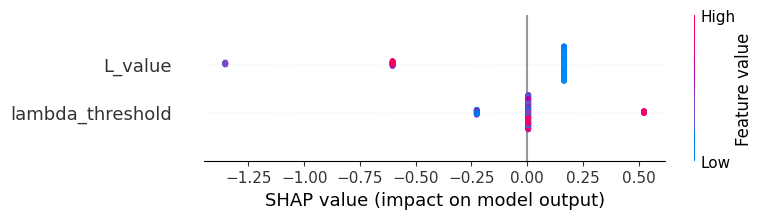

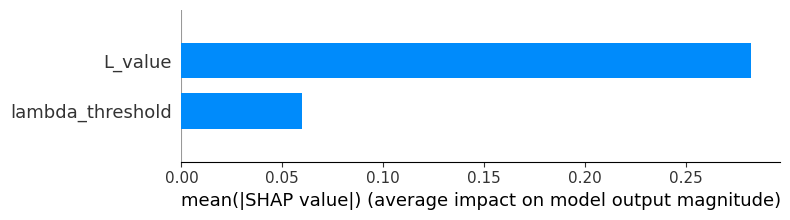

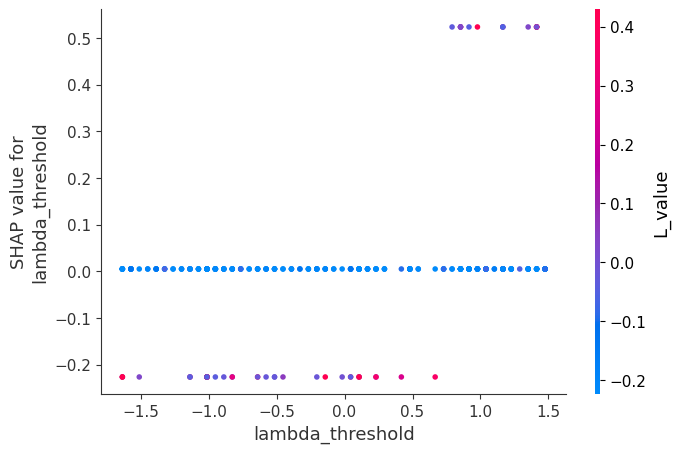

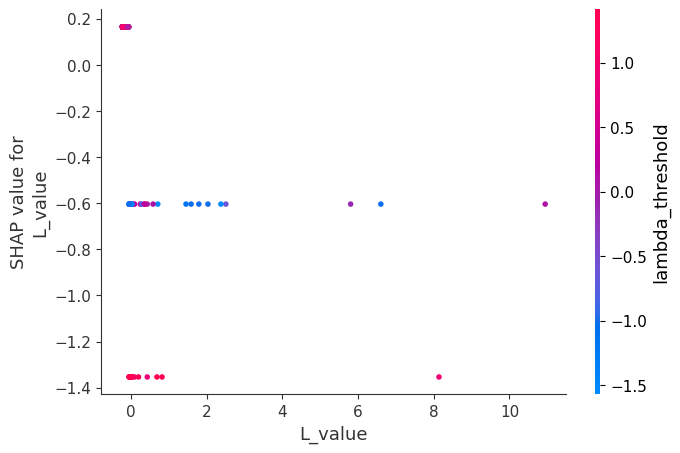



lambda_threshold   -1.634217
L_value            -0.224238
Name: 0, dtype: float64
[[ 0.08 -0.08]
 [-0.25  0.25]]
[0.17 0.83]


Base value: 0.83


/usr/local/lib/python3.10/dist-packages/shap/plots/_force_matplotlib.py:101: RuntimeWarning: divide by zero encountered in scalar divide
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)


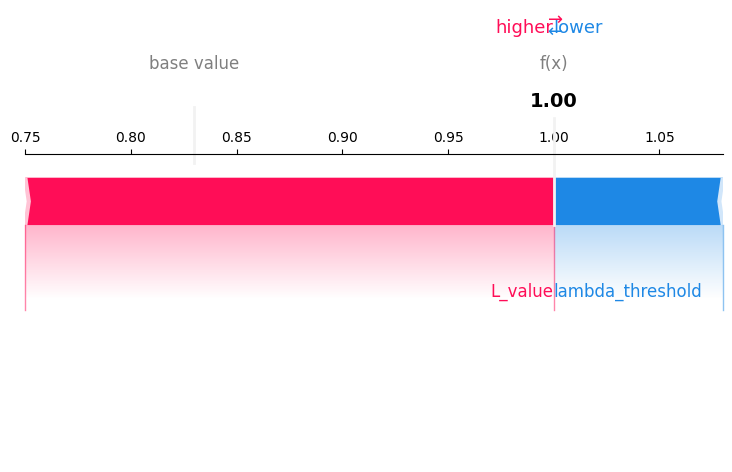

In [ ]:
! pip install shap
import shap
import pandas as pd
from sklearn.preprocessing import StandardScaler

class SHAPAgent:
    def __init__(self, model, db_agent):
        self.model = model
        self.db_agent = db_agent
        self.scaler = StandardScaler()
        self.X_test = None  # Initialisation des données de décision normalisées

    # Méthode pour récupérer et normaliser les données de décisions depuis la base
    def get_normalized_decision_data(self):
        # Récupérer les données via la méthode existante
        decision_data = self.db_agent.fetch_decisions_data_min()

        if decision_data is not None and len(decision_data) > 0:
            print("Données de décisions récupérées avec succès.")

            # Séparer les caractéristiques (lambda_threshold, l_value)
            X_decision = decision_data[:, [0, 1]]

            # Normaliser les données
            X_decision_normalized = self.scaler.fit_transform(X_decision)
            self.X_test = X_decision_normalized  # Stocker les données normalisées dans la classe
        else:
            print("Erreur: Aucune donnée de décision disponible.")

    # Méthode pour expliquer une instance spécifique avec SHAP
    def explain_instance(self):
        # Sélection de la première instance de test
        X_instance = self.X_test.iloc[0]
        print(X_instance)
        # Créer l'explainer SHAP basé sur le modèle (assurez-vous que c'est un modèle d'arbre)
        explainer = shap.TreeExplainer(self.model)
        # Calcul des valeurs SHAP pour l'instance
        shap_values = explainer.shap_values(X_instance)
        print(shap_values)
        print(explainer.expected_value)
        print("\n")
        print(f"Base value: {explainer.expected_value[1]}")
        # Initialisation de JavaScript pour les graphiques interactifs
        shap.force_plot(explainer.expected_value[1], shap_values[..., 1], feature_names=self.X_test.columns, matplotlib=True, show=True, figsize=(9,4))
        plt.show()


    # Méthode pour expliquer le modèle entier avec SHAP
    def explain_model(self):

        if self.X_test is None:
          print("Les données ne sont pas encore disponibles. Veuillez appeler 'get_normalized_decision_data' avant.")
          return

        if not isinstance(self.X_test, pd.DataFrame):
          feature_names = ['lambda_threshold', 'L_value']
          self.X_test = pd.DataFrame(self.X_test, columns=feature_names)

        # Créer l'explainer SHAP basé sur le modèle
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.X_test, approximate=True)

        # Affichage des valeurs SHAP sous forme de tableau
        self.display_shap_values_table(shap_values, self.X_test)

        # Afficher le summary plot et le bar plot
        accept_shap_values = shap_values[..., 1]
        shap.summary_plot(accept_shap_values, self.X_test)
        print("\n")
        shap.summary_plot(accept_shap_values, self.X_test, plot_type="bar")
        print("\n")
        # Afficher les contributions pour chaque classe individuellement
        shap.dependence_plot("lambda_threshold", accept_shap_values, self.X_test)
        print("\n")
        shap.dependence_plot("L_value", accept_shap_values, self.X_test)
        print("\n")

    # Méthode pour afficher les valeurs SHAP dans un tableau
    def display_shap_values_table(self, shap_values, X_test):
        # Sélectionner les valeurs SHAP pour la classe d'acceptation
        accept_shap_values = shap_values[...,1]  # Utilisation de la classe 'Accept'
        # Créer un DataFrame pour afficher les valeurs SHAP
        shap_df = pd.DataFrame(accept_shap_values, columns=X_test.columns)
        print("\nTableau des valeurs SHAP pour les décisions 'Accept':")
        print(shap_df.head())  # Afficher les premières lignes du tableau


# Exemple d'utilisation
if __name__ == "__main__":
    # Supposons que db_agent est déjà initialisé et connecté à la base de données
    db_agent = PostgreSQLAgent(db_name='', user='postgres', password='postgres')

    # Créer l'agent SHAP en utilisant le modèle déjà entraîné
    shap_agent = SHAPAgent(model=interpret_agent.model_decision, db_agent=db_agent)

    # Récupérer et normaliser les données de décisions depuis la base
    shap_agent.get_normalized_decision_data()

    # Expliquer le modèle entier
    shap_agent.explain_model()

    # Instance
    shap_agent.explain_instance()

Données de décisions récupérées avec succès.
[2.1        6.12891671]
[-1.63421712 -0.22423848]


Intercept 0.6927252711885156
Prediction_local [0.99430337]
Right: 1.0


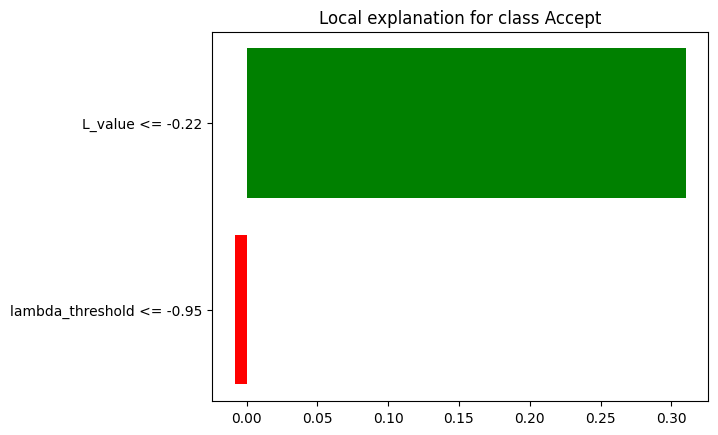

In [ ]:
!pip install lime
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import StandardScaler
import numpy as np

class LIMEAgent:
    def __init__(self, model, db_agent):
        self.model = model
        self.db_agent = db_agent
        self.X_test = None  # Initialisation des données normalisées

    # Méthode pour récupérer et normaliser les données de décisions depuis la base
    def get_normalized_decision_data(self):
        # Récupérer les données via la méthode existante dans db_agent
        decision_data = self.db_agent.fetch_decisions_data_min()

        if decision_data is not None and len(decision_data) > 0:
            print("Données de décisions récupérées avec succès.")

            # Séparer les caractéristiques pertinentes (lambda_threshold et l_value)
            X_decision = decision_data[:, [0, 1]]
            print(X_decision[2])
            # Normaliser les données
            scaler = StandardScaler()
            X_decision_normalized = scaler.fit_transform(X_decision)
            self.X_test = X_decision_normalized  # Stocker les données normalisées dans la classe
        else:
            print("Erreur: Aucune donnée de décision disponible.")

    # Méthode pour expliquer une instance spécifique avec LIME
    def explain_instance(self, X_instance):
        if self.X_test is None:
            print("Les données ne sont pas encore disponibles. Veuillez appeler 'get_normalized_decision_data' avant.")
            return

        plt.style.use('default')  # Appliquer un style avec fond blanc

        # Initialisation de l'explainer LIME
        explainer = LimeTabularExplainer(
            self.X_test,
            feature_names=['lambda_threshold', 'L_value'],  # Les noms des caractéristiques
            class_names=['Reject', 'Accept'],
            mode='classification',
            verbose=True,
        )

        print("\n")

        # Expliquer l'instance donnée (qui doit être normalisée)
        exp = explainer.explain_instance(X_instance, self.model.predict_proba, num_features=2)
        exp.show_in_notebook(show_table=True)

        fig = exp.as_pyplot_figure()
        fig.savefig("lime_explanation_white_bg.png", bbox_inches='tight', facecolor='white')

        print("\n")

# Exemple d'utilisation
if __name__ == "__main__":
    # Supposons que db_agent est déjà initialisé et connecté à la base de données
    db_agent = PostgreSQLAgent(db_name='', user='postgres', password='postgres')

    # Créer l'agent LIME en utilisant le modèle déjà entraîné et la base de données
    lime_agent = LIMEAgent(model=interpret_agent.model_decision, db_agent=db_agent)

    # Récupérer et normaliser les données de décisions depuis la base
    lime_agent.get_normalized_decision_data()

    # Exemple de nouvelle donnée à expliquer (doit être normalisée avant utilisation)
    X_instance_normalized = lime_agent.X_test[0]  # Utiliser la première instance des données normalisées
    print(X_instance_normalized)
    # Expliquer l'instance
    lime_agent.explain_instance(X_instance_normalized)


Données de décisions récupérées avec succès.
Importances des caractéristiques: [0.    0.161]


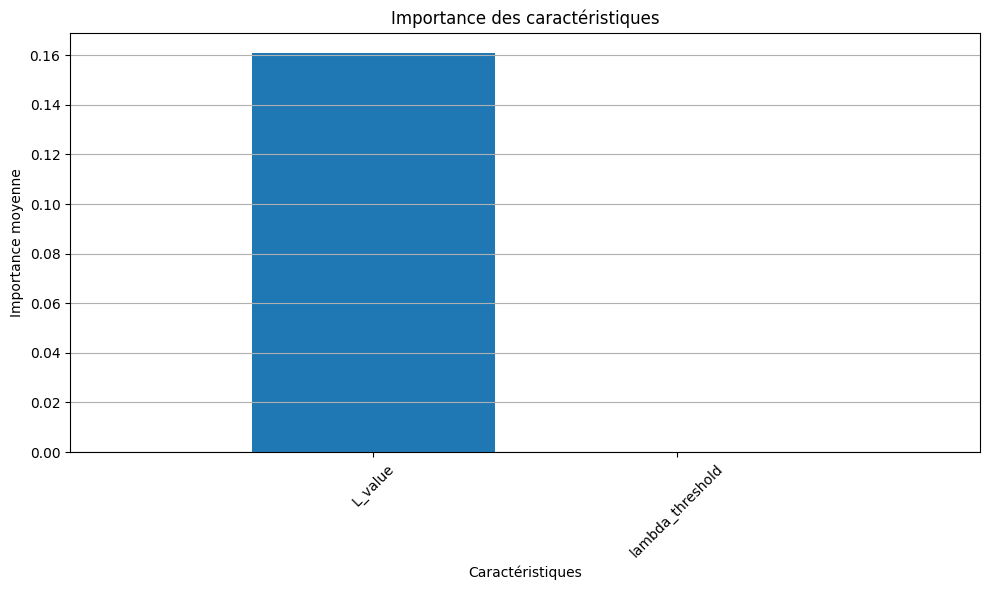

In [ ]:
from sklearn.inspection import permutation_importance

class PFI_Agent:
    def __init__(self, model, db_agent):
        self.model = model
        self.db_agent = db_agent
        self.X_test = None  # Initialisation des données normalisées
        self.y_test = None  # Initialisation des étiquettes

    def get_normalized_decision_data(self):
        # Récupérer les données de décisions via l'agent PostgreSQL
        decision_data = self.db_agent.fetch_decisions_data_min()

        if decision_data is not None and len(decision_data) > 0:
            print("Données de décisions récupérées avec succès.")

            # Séparer les caractéristiques et la cible
            self.X_test = decision_data[:, [0, 1]]  # lambda_threshold, L_value
            self.y_test = decision_data[:, 2]  # decision_made

            # Normaliser les données
            scaler = StandardScaler()
            self.X_test = scaler.fit_transform(self.X_test)
        else:
            print("Erreur: Aucune donnée de décision disponible.")

    def compute_importance(self):
        if self.X_test is None or self.y_test is None:
            print("Les données ne sont pas encore disponibles. Veuillez appeler 'get_normalized_decision_data' avant.")
            return

        result = permutation_importance(self.model, self.X_test, self.y_test, n_repeats=10, random_state=42)
        return result.importances_mean

    def plot_importance(self, importances):
        # Créer un graphique des importances
        feature_names = ['lambda_threshold', 'L_value']  # Noms des caractéristiques
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        plt.title("Importance des caractéristiques")
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=45)
        plt.xlim([-1, len(importances)])
        plt.ylabel("Importance moyenne")
        plt.xlabel("Caractéristiques")
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

# Exemple d'utilisation
if __name__ == "__main__":
    # Supposons que db_agent est déjà initialisé et connecté à la base de données
    db_agent = PostgreSQLAgent(db_name='', user='postgres', password='postgres')

    # Créer l'agent PFI en utilisant le modèle déjà entraîné
    pfi_agent = PFI_Agent(model=interpret_agent.model_decision, db_agent=db_agent)

    # Récupérer et normaliser les données de décisions depuis la base
    pfi_agent.get_normalized_decision_data()

    # Calculer les importances des caractéristiques
    importances = pfi_agent.compute_importance()
    print("Importances des caractéristiques:", importances)

    # Afficher le graphique des importances
    pfi_agent.plot_importance(importances)